In [13]:
import yfinance as yf
from IPython.display import display
import plotly.graph_objects as go
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

In [2]:
ticker = "BTC-USD"
data = yf.download(ticker, start="2022-01-01", end="2024-11-29")

data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)  # set date as index

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859


In [4]:
# Hareketli ortalamaları hesaplama
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()

# Trend sinyalleri oluşturma
data['Signal'] = 0
data.loc[data['SMA20'] > data['SMA50'], 'Signal'] = 1  # Yükseliş trendi
data.loc[data['SMA20'] < data['SMA50'], 'Signal'] = -1 # Düşüş trendi

# Grafik oluşturma
fig = go.Figure()
fig.add_trace(go.Candlestick(x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close'],
                            name='BTC-USD'))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA20'], name='SMA20'))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA50'], name='SMA50'))
fig.show()

In [5]:
def calculate_rsi(data, periods=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data)
data['RSI_Signal'] = 0
data.loc[data['RSI'] > 70, 'RSI_Signal'] = -1  # Aşırı alım
data.loc[data['RSI'] < 30, 'RSI_Signal'] = 1   # Aşırı satım

In [7]:
# MACD hesaplama
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

# MACD sinyalleri
data['MACD_Signal'] = 0
data.loc[data['MACD'] > data['Signal_Line'], 'MACD_Signal'] = 1
data.loc[data['MACD'] < data['Signal_Line'], 'MACD_Signal'] = -1

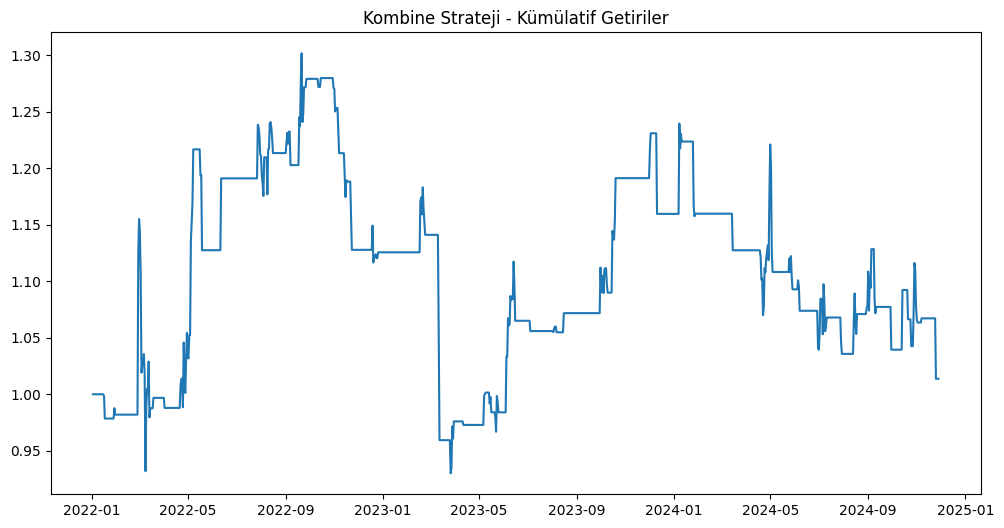

Toplam Getiri: 1.37%
Yıllık Getiri: 0.32%


C:\Users\ismai\AppData\Local\Temp\ipykernel_40600\209404650.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [11]:
# Tüm stratejileri birleştiren kombine sinyal oluşturma
data['Combined_Signal'] = 0

# En az 2 stratejinin aynı sinyali vermesi durumunda işlem yap
data['Combined_Signal'] = np.where(
    (data['Signal'] + data['RSI_Signal'] + data['MACD_Signal'] >= 2), 1,  # En az 2 alış sinyali
    np.where(
        (data['Signal'] + data['RSI_Signal'] + data['MACD_Signal'] <= -2), -1,  # En az 2 satış sinyali
        0  # Diğer durumlar
    )
)

# Kombine stratejinin performansını hesaplama
data['Strategy_Returns'] = data['Combined_Signal'] * data['Close'].pct_change()
cumulative_returns = (1 + data['Strategy_Returns']).cumprod()

# Sonuçları görselleştirme
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Kombine Strateji - Kümülatif Getiriler')
plt.show()

# Basit performans metrikleri
total_return = cumulative_returns[-1] - 1
print(f'Toplam Getiri: {total_return:.2%}')
print(f'Yıllık Getiri: {(total_return / (len(data) / 252)):.2%}')  # 252 trading günü

In [14]:
# Plotly ile interaktif grafik oluşturma
# Ana grafik ve 2 alt grafik için figure oluşturma
fig = go.Figure()

# Subplot'ları oluşturma
fig = make_subplots(rows=3, cols=1, 
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                    row_heights=[0.6, 0.2, 0.2],
                    subplot_titles=('BTC-USD Fiyat Grafiği', 'RSI', 'MACD'))

# Ana grafik - Mum grafiği ve MA'lar
fig.add_trace(go.Candlestick(x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close'],
                            name='BTC-USD'), row=1, col=1)

fig.add_trace(go.Scatter(x=data.index, y=data['SMA20'], 
                        name='SMA20', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['SMA50'], 
                        name='SMA50', line=dict(color='blue')), row=1, col=1)

# Alım-satım sinyalleri
buy_signals = data[data['Combined_Signal'] == 1].index
fig.add_trace(go.Scatter(x=buy_signals, 
                        y=data.loc[buy_signals, 'Low'] * 0.99,
                        mode='markers',
                        marker=dict(symbol='triangle-up', size=15, color='green'),
                        name='Alış Sinyali'), row=1, col=1)

sell_signals = data[data['Combined_Signal'] == -1].index
fig.add_trace(go.Scatter(x=sell_signals, 
                        y=data.loc[sell_signals, 'High'] * 1.01,
                        mode='markers',
                        marker=dict(symbol='triangle-down', size=15, color='red'),
                        name='Satış Sinyali'), row=1, col=1)

# RSI grafiği
fig.add_trace(go.Scatter(x=data.index, y=data['RSI'], 
                        name='RSI', line=dict(color='purple')), row=2, col=1)
# RSI için 70 ve 30 seviyeleri
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

# MACD grafiği
fig.add_trace(go.Scatter(x=data.index, y=data['MACD'], 
                        name='MACD', line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], 
                        name='Sinyal', line=dict(color='orange')), row=3, col=1)
# MACD Histogram
fig.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], 
                    name='Histogram', marker_color='gray'), row=3, col=1)

# Grafik düzeni ayarları
fig.update_layout(
    title='BTC-USD Teknik Analiz Grafiği',
    yaxis_title='Fiyat',
    xaxis_title='Tarih',
    template='plotly_white',
    xaxis_rangeslider_visible=False,
    height=900  # Grafik yüksekliğini artır
)

# Zaman aralığı seçimi için butonlar
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.7,
            y=1.1,
            showactive=True,
            buttons=list([
                dict(
                    label="Tümü",
                    method="relayout",
                    args=[{"xaxis.autorange": True, "yaxis.autorange": True}]
                ),
                dict(
                    label="Son 6 Ay",
                    method="relayout",
                    args=[{"xaxis.range": [data.index[-180], data.index[-1]]}]
                ),
                dict(
                    label="Son 3 Ay",
                    method="relayout",
                    args=[{"xaxis.range": [data.index[-90], data.index[-1]]}]
                ),
                dict(
                    label="Son 1 Ay",
                    method="relayout",
                    args=[{"xaxis.range": [data.index[-30], data.index[-1]]}]
                )
            ]),
        )
    ]
)

# Grafiği göster
fig.show()